# predict

### setup

In [1]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

#Global vars
CV=4


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


## load sets

In [2]:
import joblib
X_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_train.joblib', 'rb'))
y_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib', 'rb'))
X_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_test.joblib', 'rb'))
y_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_test.joblib', 'rb'))

### train logistic regression with cross validation for regularization

In [3]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV(max_iter=1000,
#                                solver='liblinear',
                                 scoring='recall',
                               n_jobs=4)

#train
log_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=4, penalty='l2',
                     random_state=None, refit=True, scoring='recall',
                     solver='lbfgs', tol=0.0001, verbose=0)

### logistic regression cross validation performance

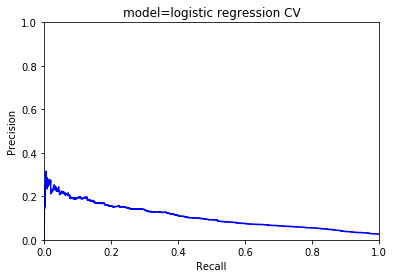

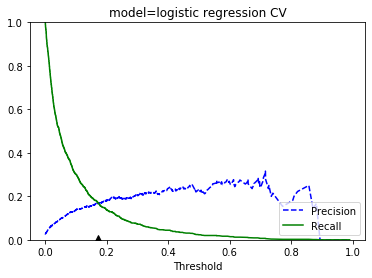

Confusion matrix for threshold = 0.17:
[[33501   755]
 [  756   152]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34256
           1       0.17      0.17      0.17       908

    accuracy                           0.96     35164
   macro avg       0.57      0.57      0.57     35164
weighted avg       0.96      0.96      0.96     35164



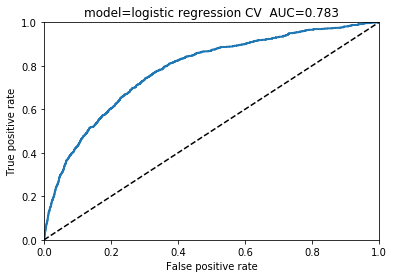

In [4]:
#logistic regression cross validation
probs_log_cv = cross_val_predict(log_reg, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_log_cv = probs_log_cv[:, 1]
log_perf_cv = get_model_performance('logistic regression CV', X_train, scores_log_cv, y_train, pos_label=1)

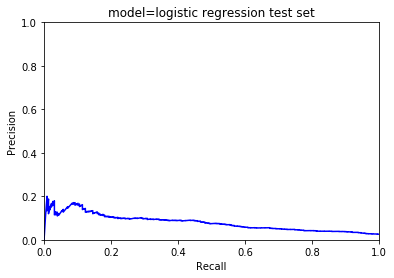

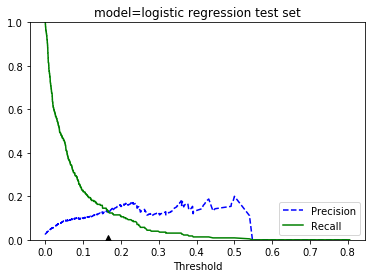

Confusion matrix for threshold = 0.17:
[[8368  197]
 [ 198   29]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8565
           1       0.13      0.13      0.13       227

    accuracy                           0.96      8792
   macro avg       0.55      0.55      0.55      8792
weighted avg       0.95      0.96      0.96      8792



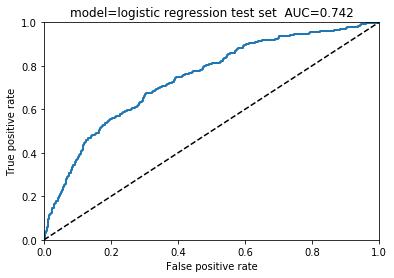

In [5]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

In [6]:
print(log_perf_cv['auc'])

0.783


## Random forest

In [7]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=1
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2]
min_samples_leaf = [1]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'precision',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.9s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.8s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.8s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=10 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=10, total=   2.8s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.3s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.4s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.4s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.4s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.8min finished


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.5s
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


In [8]:
#best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}

In [9]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=321, verbose=0,
                       warm_start=False)

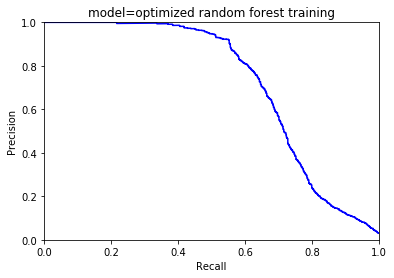

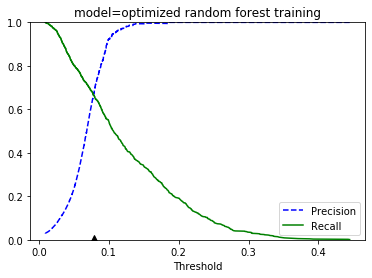

Confusion matrix for threshold = 0.08:
[[33953   303]
 [  304   604]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     34256
           1       0.67      0.67      0.67       908

    accuracy                           0.98     35164
   macro avg       0.83      0.83      0.83     35164
weighted avg       0.98      0.98      0.98     35164



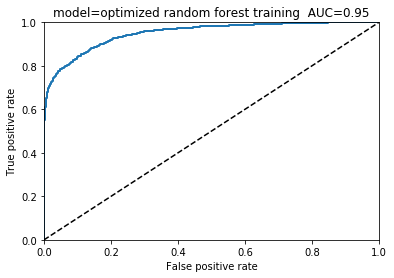

In [10]:
#optimized model performance on training set
scores_opt = rf_opt.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

### random forest cross validation performance

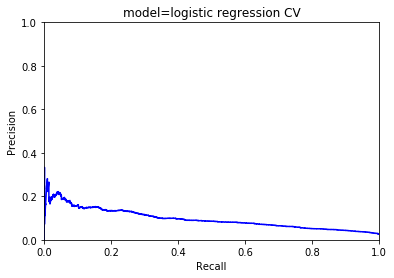

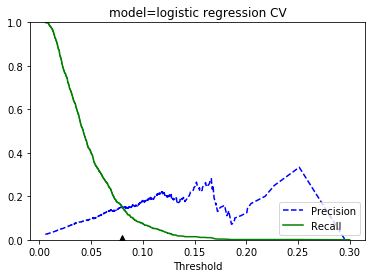

Confusion matrix for threshold = 0.08:
[[33487   769]
 [  770   138]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34256
           1       0.15      0.15      0.15       908

    accuracy                           0.96     35164
   macro avg       0.56      0.56      0.56     35164
weighted avg       0.96      0.96      0.96     35164



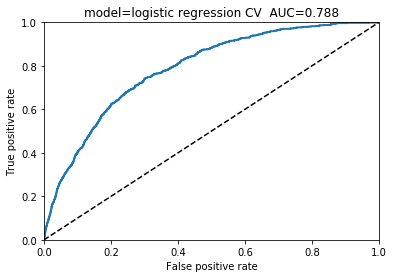

0.788


In [11]:
#logistic regression cross validation
probs_rf_cv = cross_val_predict(rf_opt, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

### plot AUC from the two cross validations

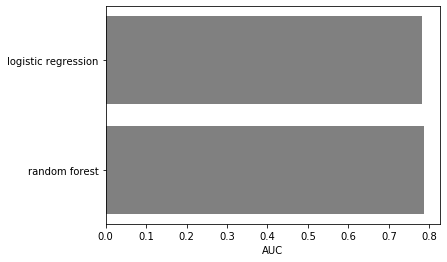

In [12]:
mods = ['logistic regression',
       'random forest']
performance = [log_perf_cv['auc'],
               rf_perf_cv['auc']]
fig, ax = plt.subplots()
y_pos = np.arange(len(mods))
ax.barh(y_pos, performance, align='center', color='grey')
ax.set_yticks(y_pos)
ax.set_yticklabels(mods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('AUC')
plt.show()
auc_df = pd.DataFrame({'model':mods, 'auc':performance})
auc_df.to_csv('../data/for_plotting/auc_comparison.csv', index=False)

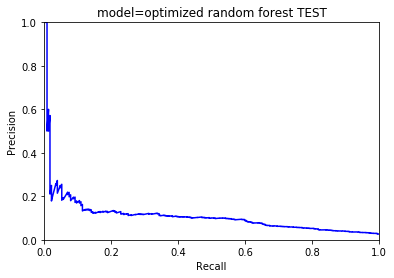

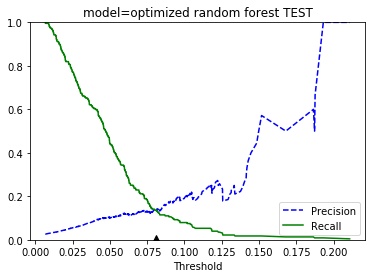

Confusion matrix for threshold = 0.08:
[[8370  195]
 [ 196   31]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8565
           1       0.14      0.14      0.14       227

    accuracy                           0.96      8792
   macro avg       0.56      0.56      0.56      8792
weighted avg       0.96      0.96      0.96      8792



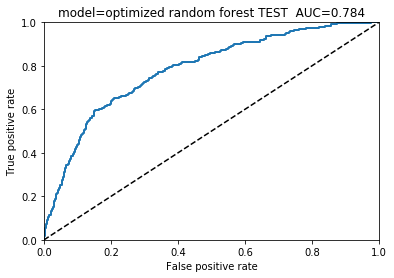

Confusion matrix for threshold = 0.04:
[[7148 1417]
 [  90  137]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      8565
           1       0.09      0.60      0.15       227

    accuracy                           0.83      8792
   macro avg       0.54      0.72      0.53      8792
weighted avg       0.96      0.83      0.89      8792



['../data/for_app/performance.joblib']

In [100]:
#predict for test set
exec(open("my_functions.py").read())
test_scores = rf_opt.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.04
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))
joblib.dump(test_perf, '../data/for_app/performance.joblib')

(array([5.71e+03, 1.91e+03, 7.20e+02, 2.96e+02, 9.20e+01, 3.70e+01,
        1.90e+01, 3.00e+00, 3.00e+00, 2.00e+00]),
 array([0.00494557, 0.02553449, 0.04612341, 0.06671232, 0.08730124,
        0.10789016, 0.12847908, 0.149068  , 0.16965692, 0.19024584,
        0.21083476]),
 <a list of 10 Patch objects>)

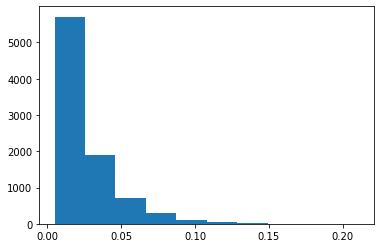

In [101]:
test_scores = rf_opt.predict_proba(X_test)[:, 1]
plt.hist(test_scores)
# plt.show()
# plt.hist(test_scores[y_test==1])
# plt.show()
# plt.hist(test_scores[y_test==0])
# plt.show()
# max(test_scores)

### write out performance for app

In [126]:
import joblib

auc = test_perf['auc']
#format precision and recall data
pr_dat = pd.DataFrame({'Recall':test_perf['recall'],
                         'Precision':test_perf['precision'],
                         'threshold':test_perf['recall_prec_thresholds']})
pr_long = pd.melt(pr_dat, id_vars=['threshold'], value_vars=['Recall', 'Precision'], var_name='Stat')

#format ROC data
roc_dat = pd.DataFrame({'False Positive Rate':test_perf['fpr'],
                         'True Positive Rate':test_perf['tpr'],
                         'threshold':test_perf['roc_thresholds']})
tot = roc_dat['False Positive Rate'] + roc_dat['False Positive Rate']
roc_dat = roc_dat.loc[tot>0,:]

#save for app
pr_dat

Recall  Precision  threshold
0     1.000000   0.026429   0.006604
1     0.995595   0.026316   0.006607
2     0.995595   0.026319   0.006611
3     0.995595   0.026322   0.006627
4     0.995595   0.026325   0.006628
...        ...        ...        ...
8584  0.013216   0.600000   0.186524
8585  0.008811   0.500000   0.187313
8586  0.008811   0.666667   0.187649
8587  0.008811   1.000000   0.193161
8588  0.004405   1.000000   0.210835

[8589 rows x 3 columns]

In [133]:
#select by precision
target_precision = 0.2
pr_dat['dist'] = abs(pr_dat['Precision']-target_precision)
pr_sub1 = pr_dat.loc[dist==min(dist),:]
pr_sub2 = pr_sub1.loc[pr_sub1['Recall']==max(pr_sub1['Recall']),]
pr_sub3 = pr_sub2.loc[pr_sub2['threshold']==max(pr_sub2['threshold']),]
print(pr_sub1)
print(pr_sub2)
target_recall = pr_sub3['Recall']
target_threshold = pr_sub3['threshold']
print(target_recall)
print(target_threshold)

        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0
8504  0.074890        0.2   0.101834   0.0
8529  0.052863        0.2   0.110114   0.0
8564  0.022026        0.2   0.129875   0.0
        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0
8499    0.079295
Name: Recall, dtype: float64
8499    0.100953
Name: threshold, dtype: float64


### plot precision

In [181]:
#PLOT WITH SELECTED PRECISION
import plotly.graph_objects as go
select_precision = 0.2
pr_dat['dist'] = abs(pr_dat['Precision']-select_precision)
pr_sub1 = pr_dat.loc[pr_dat['dist']==min(pr_dat['dist']),:]
pr_sub2 = pr_sub1.loc[pr_sub1['Recall']==max(pr_sub1['Recall']),]
pr_sub3 = pr_sub2.loc[pr_sub2['threshold']==max(pr_sub2['threshold']),]
print(pr_sub1)
print(pr_sub2)
target_recall = float(pr_sub3['Recall'])
target_threshold = float(pr_sub3['threshold'])
target_precision = float(pr_sub3['Precision'])


# Create traces
fig = go.Figure()
#add precision trace
fig.add_trace(go.Scatter(x=pr_dat['threshold'], y=pr_dat['Precision'],
                    mode='lines',
                    name='Precision', marker_color='firebrick'))
#add recall trace
fig.add_trace(go.Scatter(x=pr_dat['threshold'], y=pr_dat['Recall'],
                    mode='lines',
                    name='Recall', marker_color='grey'))
#add vertical intersect line
fig.add_shape(
            type="line",
            x0=target_threshold,
            y0=0,
            x1=target_threshold,
            y1=target_recall,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"))
#add horizontal intersect line
fig.add_shape(
            type="line",
            x0=0,
            y0=target_recall,
            x1=target_threshold,
            y1=target_recall,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"))
fig.add_trace(go.Scatter(
    x=[target_threshold],
    y=[target_precision],
    mode="markers",
    name="Precision target = {}".format(round(select_precision, 3)),
    marker=dict(size=[12],
               color = ['firebrick'])
))
fig.add_trace(go.Scatter(
    x=[target_threshold],
    y=[target_recall],
    mode="markers",
    name="Recall result = {}".format(round(target_recall, 3)),
    marker_color='grey',
    marker=dict(size=[12])
))
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                 yaxis_title="Stat value",
                 xaxis_title='Readmission probability threshold')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black')
fig.show()

        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0
8504  0.074890        0.2   0.101834   0.0
8529  0.052863        0.2   0.110114   0.0
8564  0.022026        0.2   0.129875   0.0
        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0


### plot target recall

In [182]:
#PLOT WITH SELECTED PRECISION
import plotly.graph_objects as go
select_recall = 0.2
pr_dat['dist'] = abs(pr_dat['Recall']-select_recall)
pr_sub1 = pr_dat.loc[pr_dat['dist']==min(pr_dat['dist']),:]
pr_sub2 = pr_sub1.loc[pr_sub1['Precision']==max(pr_sub1['Precision']),]
pr_sub3 = pr_sub2.loc[pr_sub2['threshold']==max(pr_sub2['threshold']),]
print(pr_sub1)
print(pr_sub2)
print(pr_sub3)
target_recall = float(pr_sub3['Recall'])
target_threshold = float(pr_sub3['threshold'])
target_precision = float(pr_sub3['Precision'])


# Create traces
fig = go.Figure()
#add precision trace
fig.add_trace(go.Scatter(x=pr_dat['threshold'], y=pr_dat['Precision'],
                    mode='lines',
                    name='Precision', marker_color='firebrick'))
#add recall trace
fig.add_trace(go.Scatter(x=pr_dat['threshold'], y=pr_dat['Recall'],
                    mode='lines',
                    name='Recall', marker_color='grey'))
#add vertical intersect line
fig.add_shape(
            type="line",
            x0=target_threshold,
            y0=0,
            x1=target_threshold,
            y1=target_recall,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"))
#add horizontal intersect line
fig.add_shape(
            type="line",
            x0=0,
            y0=target_recall,
            x1=target_threshold,
            y1=target_recall,
            line=dict(
                color="grey",
                width=1,
                dash="dashdot"))
fig.add_trace(go.Scatter(
    x=[target_threshold],
    y=[target_precision],
    mode="markers",
    name="Precision result = {}".format(round(select_precision, 3)),
    marker=dict(size=[12],
               color = ['firebrick'])
))
fig.add_trace(go.Scatter(
    x=[target_threshold],
    y=[target_recall],
    mode="markers",
    name="Recall target = {}".format(round(target_recall, 3)),
    marker_color='grey',
    marker=dict(size=[12])
))
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                 yaxis_title="Stat value",
                 xaxis_title='Readmission probability threshold')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black')
fig.show()

        Recall  Precision  threshold      dist
8243  0.198238   0.130058   0.072989  0.001762
        Recall  Precision  threshold      dist
8243  0.198238   0.130058   0.072989  0.001762
        Recall  Precision  threshold      dist
8243  0.198238   0.130058   0.072989  0.001762


In [130]:

#PLOT PLAIN CURVES
import plotly.express as px

#plot precision recall curve
fig = px.line(pr_long,
              x="threshold",
              y="value",
              color="Stat",
              hover_name="Stat",
              title="Precision-Recall curves",
             color_discrete_map={'Recall':'grey',
                                'Precision':'firebrick'})
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)',
                 yaxis_title="Stat value",
                 xaxis_title='Readmission probability threshold')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black')
fig.show()

# #plot the roc curve
# fig = px.line(roc_dat,
#               y="True Positive Rate",
#               x="False Positive Rate",
#               color_discrete_sequence=['grey'],
#              title='ROC curve (AUC = {})'.format(auc))
# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
# fig.update_xaxes(showline=True, linewidth=1.5, linecolor='black')
# fig.update_yaxes(showline=True, linewidth=1.5, linecolor='black')
# fig.show()

In [132]:
#select by precision
target_precision = 0.2
pr_dat['dist'] = abs(pr_dat['Precision']-target_precision)
pr_sub1 = pr_dat.loc[dist==min(dist),:]
pr_sub2 = pr_sub1.loc[pr_sub1['Recall']==max(pr_sub1['Recall']),]
pr_sub3 = pr_sub2.loc[pr_sub2['threshold']==max(pr_sub2['threshold']),]
print(pr_sub1)
print(pr_sub2)
target_recall = pr_sub3['Recall']
target_threshold = pr_sub3['threshold']
print(target_recall)
print(target_threshold)

        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0
8504  0.074890        0.2   0.101834   0.0
8529  0.052863        0.2   0.110114   0.0
8564  0.022026        0.2   0.129875   0.0
        Recall  Precision  threshold  dist
8499  0.079295        0.2   0.100953   0.0
8499    0.079295
Name: Recall, dtype: float64
8499    0.100953
Name: threshold, dtype: float64


In [45]:
import plotly.express as px
df = px.data.gapminder().query("continent != 'Asia'") # remove Asia for visibility
fig = px.line(df, x="year", y="lifeExp", color="continent",
              line_group="country", hover_name="country")
fig.show()
df

country continent  year  lifeExp       pop    gdpPercap iso_alpha  \
12     Albania    Europe  1952   55.230   1282697  1601.056136       ALB   
13     Albania    Europe  1957   59.280   1476505  1942.284244       ALB   
14     Albania    Europe  1962   64.820   1728137  2312.888958       ALB   
15     Albania    Europe  1967   66.220   1984060  2760.196931       ALB   
16     Albania    Europe  1972   67.690   2263554  3313.422188       ALB   
...        ...       ...   ...      ...       ...          ...       ...   
1699  Zimbabwe    Africa  1987   62.351   9216418   706.157306       ZWE   
1700  Zimbabwe    Africa  1992   60.377  10704340   693.420786       ZWE   
1701  Zimbabwe    Africa  1997   46.809  11404948   792.449960       ZWE   
1702  Zimbabwe    Africa  2002   39.989  11926563   672.038623       ZWE   
1703  Zimbabwe    Africa  2007   43.487  12311143   469.709298       ZWE   

      iso_num  
12          8  
13          8  
14          8  
15          8  
16          8  
...       ...  
1699      716  
1700      716  
1701      716  
1702      716  
1703      716  

[1308 rows x 8 columns]

### get importance

In [22]:
importances = rf_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = X_test.columns[indices]
idat = pd.DataFrame({'feature':features,
                     'importance': importances,
                   'std': std,
                   'index':indices})
idat = idat.sort_values('importance', ascending=False)
idat

feature  importance       std  index
163  diagnosis_icd9_27650    0.035414  0.022593     35
0    total_diagnosis_icd9    0.027908  0.015893    163
1                     age    0.024908  0.015251      0
72    diagnosis_icd9_V422    0.019661  0.023285    149
207   diagnosis_icd9_5722    0.015067  0.009163    102
..                    ...         ...       ...    ...
365        religion_HINDU    0.000000  0.000000    396
322   procedure_icd9_3521    0.000000  0.000000    172
324   procedure_icd9_0331    0.000000  0.000000    166
361         language_AMER    0.000000  0.000000    358
326  diagnosis_icd9_34982    0.000000  0.000000     56

[457 rows x 4 columns]

### save for app

In [23]:
import joblib
joblib.dump(idat.loc[idat['importance']>0,:], '../data/for_app/importances.joblib')

['../data/for_app/importances.joblib']